This program trains and visualizes the outputs of a simple Deep
Convolutional GAN (DCGAN) to generate realistic-looking (but fake) images of clothing.

a. Use the FashionMNIST training dataset to train the DCGAN. Images are grayscale and size 28 × 28.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import tensorflow as tf
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# fashion_mnist = tf.keras.datasets.fashion_mnist

# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [ ]:
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

b. Define discriminator architecture

In [ ]:
"""
class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=64,
                           kernel_size=5,
                           stride=2,
                           padding=3)
    self.leakyrelu1 = 0.3
    self.dropout1 = 0.3
    
    self.conv2 = nn.Conv2d(in_channels=64,
                           out_channels=128,
                           kernel_size=5,
                           stride=2,
                           padding=3)
    self.leakyrelu2 = 0.3
    self.dropout2 = 0.3

    self.fc1 = nn.Linear(128 * 7 * 7, 1)
  
  def forward(self, x):
    ### TRY LEAKYRELU BEFORE DROPOUT, IF SHIT GOES WRONG ###
    x = F.dropout2d((F.leaky_relu(self.conv1(x), self.leakyrelu1)),
                    p=self.dropout1)
    x = F.dropout2d((F.leaky_relu(self.conv2(x), self.leakyrelu2)),
                    p=self.dropout2)
    return self.fc1(torch.flatten(x, start_dim=1))
"""

class Discriminator(nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    self.model = nn.Sequential(
        nn.Conv2d(in_channels=1,
                  out_channels=64,
                  kernel_size=5,
                  stride=2,
                  padding=2
        ),
        nn.LeakyReLU(0.3),
        nn.Dropout(0.3),

        nn.Conv2d(in_channels=64,
                  out_channels=128,
                  kernel_size=5,
                  stride=2,
                  padding=2
        ),
        nn.LeakyReLU(0.3),
        nn.Dropout(0.3),

        nn.Flatten(),
        nn.Linear(128 * 7 * 7, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

discriminator = Discriminator()
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.3)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.3)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=1, bias=True)
    (8): Sigmoid()
  )
)


c. Define generator architecture

 

In [ ]:
"""
class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()

    self.fc1 = nn.Linear(100, 7 * 7 * 256, bias=False)

    self.conv1 = nn.ConvTranspose2d(in_channels=256,
                                    out_channels=128,
                                    kernel_size=5,
                                    padding=4,        # padding = 3 or 4??
                                    bias=False)      
    self.leakyrelu1 = 0.3

    self.conv2 = nn.ConvTranspose2d(in_channels=128,
                                    out_channels=64,
                                    kernel_size=5,
                                    stride=2,
                                    padding=3,
                                    bias=False)
    self.leakyrelu2 = 0.3

    self.conv3 = nn.ConvTranspose2d(in_channels=64,
                                    out_channels=1,
                                    kernel_size=5,
                                    stride=2,
                                    padding=3,
                                    bias=False)
    self.leakyrelu3 = 0.3

  def forward(self, x):
    x = torch.reshape(self.fc1(x), [1, 256, 7, 7])
    x = F.leaky_relu(nn.BatchNorm2d(self.conv1(x)), self.leakyrelu1)
    x = F.leaky_relu(nn.BatchNorm2d(self.conv2(x)), self.leakyrelu2)
    x = F.leaky_relu(F.tanh(self.conv3(x)), self.leakyrelu3)
    return x
"""

class Generator(nn.Module):

  def __init__(self):
    super(Generator, self).__init__()
    self.model = nn.Sequential(
        # nn.Linear(100, [7, 7, 256], bias=False),

        nn.ConvTranspose2d(in_channels=100,
                           out_channels=256,
                           kernel_size=7,
                           stride=1,
                           padding=0,
                           bias=False
        ),

        nn.ConvTranspose2d(in_channels=256,       # 7 -> 7
                           out_channels=128,
                           kernel_size=5,
                           stride=2,
                           padding=5,    
                           bias=False,
                           # output_padding=1
        ),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.3),
        
        nn.ConvTranspose2d(in_channels=128,       # 7 -> 14
                           out_channels=64,
                           kernel_size=5,
                           stride=2,
                           padding=2,
                           bias=False,
                           output_padding=1
        ),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.3),

        nn.ConvTranspose2d(in_channels=64,        # 14 -> 28
                           out_channels=1,
                           kernel_size=5,
                           stride=2,
                           padding=2,
                           bias=False,
                           output_padding=1
        ),
        nn.Tanh()
    )

  def forward(self, x):
    return self.model(x)

generator = Generator()
print(generator)


Generator(
  (model): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(5, 5), bias=False)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.3)
    (4): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.3)
    (7): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (8): Tanh()
  )
)


d. Define loss and optimizer

In [ ]:
LEARNING_RATE = 1e-4
opt_d = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE)
opt_g = optim.Adam(generator.parameters(), lr=LEARNING_RATE)
loss = nn.BCELoss()


e. Training

In [ ]:
Z = 100
BATCH_SIZE = 16
EPOCH = 50
EPOCH_OF_CHOICE = [0, 9, 29, 49]
loss_ds = []
loss_gs = []

imgs = []

generator = generator.to(device)
discriminator = discriminator.to(device)
dataloader = DataLoader(train_set, batch_size=BATCH_SIZE)

for epoch in range(EPOCH):
  print(f'Training Epoch : {epoch+1} / {EPOCH}.')
  loss_d_running = []
  loss_g_running = []
  for i, (real,_) in enumerate(dataloader):
    z_vector = torch.randn(BATCH_SIZE, Z, 1, 1).to(device)
    fake = generator(z_vector)
    
    real_d = discriminator(real.to(device)).reshape(-1)
    fake_d = discriminator(fake.detach()).reshape(-1)
    loss_d = (
        loss(real_d, torch.ones_like(real_d)) +
        loss(fake_d, torch.zeros_like(fake_d))
    )
    loss_d_running.append(loss_d)
    discriminator.zero_grad()
    loss_d.backward()
    opt_d.step()

    img = discriminator(fake).view(-1)
    # imgs.append(img)
    loss_g = loss(img, torch.ones_like(img))
    loss_g_running.append(loss_g)
    generator.zero_grad()
    loss_g.backward()
    opt_g.step()
  loss_ds.append(torch.mean(torch.FloatTensor(loss_d_running)))
  loss_gs.append(torch.mean(torch.FloatTensor(loss_g_running)))
  print(f"loss_d: {loss_ds[-1]:.3f}, loss_g: {loss_gs[-1]:.3f}.\n")
  if epoch in EPOCH_OF_CHOICE:
    fake_demo = generator(torch.randn(BATCH_SIZE, Z, 1, 1).to(device))
    imgs.append(fake_demo)
    print('Intermediate results collected.\n')


Training Epoch : 1 / 50.
loss_d: 0.934, loss_g: 1.595.

Intermediate results collected.

Training Epoch : 2 / 50.
loss_d: 0.928, loss_g: 1.312.

Training Epoch : 3 / 50.
loss_d: 0.919, loss_g: 1.354.

Training Epoch : 4 / 50.
loss_d: 0.855, loss_g: 1.460.

Training Epoch : 5 / 50.
loss_d: 0.809, loss_g: 1.552.

Training Epoch : 6 / 50.
loss_d: 0.760, loss_g: 1.652.

Training Epoch : 7 / 50.
loss_d: 0.733, loss_g: 1.733.

Training Epoch : 8 / 50.
loss_d: 0.699, loss_g: 1.818.

Training Epoch : 9 / 50.
loss_d: 0.677, loss_g: 1.890.

Training Epoch : 10 / 50.
loss_d: 0.649, loss_g: 1.956.

Intermediate results collected.

Training Epoch : 11 / 50.
loss_d: 0.615, loss_g: 2.057.

Training Epoch : 12 / 50.
loss_d: 0.600, loss_g: 2.116.

Training Epoch : 13 / 50.
loss_d: 0.563, loss_g: 2.220.

Training Epoch : 14 / 50.
loss_d: 0.558, loss_g: 2.286.

Training Epoch : 15 / 50.
loss_d: 0.530, loss_g: 2.359.

Training Epoch : 16 / 50.
loss_d: 0.521, loss_g: 2.408.

Training Epoch : 17 / 50.
loss_

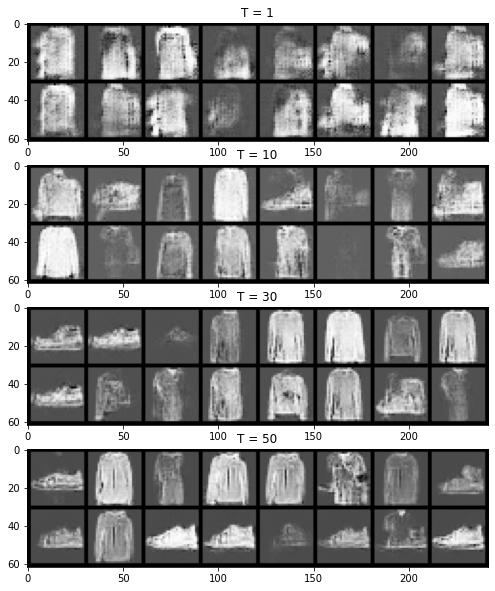

In [29]:
plt.figure(figsize=(10, 10))
for i, sets in enumerate(imgs):
  img_grid = torchvision.utils.make_grid(
        sets[:16], normalize=True
  )
  img_grid_cpu = img_grid.cpu().numpy()
  plt.subplot(len(EPOCH_OF_CHOICE), 1, i+1)
  plt.imshow(np.transpose(img_grid_cpu, (1, 2, 0)))
  plt.title(f'T = {EPOCH_OF_CHOICE[i]+1}')

f. Loss curves

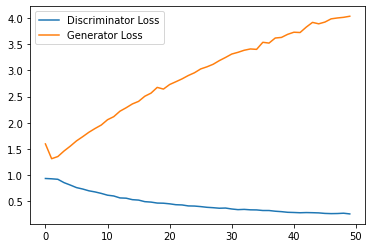

In [ ]:
plt.plot(loss_ds, label='Discriminator Loss')
plt.plot(loss_gs, label='Generator Loss')
plt.legend()

Observation:

Discriminator Loss has been steadly decreasing while Generator Loss has been increasing. This is reasonable because by defination,
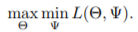, and loss is expected to maximized for generator and minimized for discriminator. Further, as discriminator becomes more accurate, it's becoming more difficult to generator to "fool" discriminator, therefore generator loss is barely possible to decrease.